In [1]:
import numpy as np
import pandas as pd
import os
import math
import cv2

from matplotlib import pyplot
import matplotlib.patches as patches

from skimage import measure
from skimage.transform import resize

import seaborn as sns
import pydicom as dcm

from sklearn import metrics
from sklearn.metrics import classification_report

import keras
keras.config.disable_traceback_filtering()


In [2]:
import warnings
warnings.filterwarnings('ignore')
import os

# Disable preallocation of GPU memory
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

# Configure XLA flags for GPU algorithms and force single-thread compilation
os.environ["XLA_FLAGS"] = "--xla_gpu_strict_conv_algorithm_picker=false --xla_gpu_force_compilation_parallelism=1"


In [3]:
import tensorflow as tf
import tensorflow.keras.utils as pltUtil
from tensorflow.keras.utils import Sequence

from tensorflow.keras.layers import Layer, Concatenate, UpSampling2D, Conv2D, Reshape, BatchNormalization, Activation
from tensorflow.keras.models import Model
from keras import backend as K


#For MobileNet
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input

#For ResNet50
from tensorflow.keras.applications.resnet import ResNet50

#For tunning of model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

In [4]:
data_dir = '/kaggle/input/rsna-pneumonia-detection-challenge/'

train_images = data_dir + 'stage_2_train_images'

In [5]:
class image_metadata():
    """
    Arguments:
        setName = name of the dataset
        file = filename
    """
    
    def __init__(self, setName, file):
        self.setName = setName
        self.file = file
    
    def __repr__(self):
        #a special method used to represent a class's objects as a string
        return self.imagePath()
    
    def imagePath(self):
        return os.path.join(self.setName, self.file)

In [6]:
#function to load image metadata
def loadimagemetadata(dataSetName):
    """
    Arguments:
        dataSetName: path of the data set folder
    """
    
    imageMetadata = []
    for f in os.listdir(dataSetName):
        ext = os.path.splitext(f)[1]
        if ext == '.dcm':
            imageMetadata.append(image_metadata(dataSetName, f))
    return np.array(imageMetadata)

In [7]:
#function to load image and patientId
def loadImage(path):
    """
    Arguments:
        path: path of the image
    """
    
    img = dcm.dcmread(path)
    return img

def getImgId(imgPath):
    """
    Arguments:
        imgPath: path of the image
    """
    
    return str(imgPath).split(".dcm")[0].split("/")[5]

In [8]:
trainingSetImageMetadata = loadimagemetadata(train_images)
print('Shape of training set image metadata: ', trainingSetImageMetadata.shape)
print("Sample image path: ", trainingSetImageMetadata[0])

Shape of training set image metadata:  (26684,)
Sample image path:  /kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/c3b05294-29be-46e4-8a51-96fd211e4ca5.dcm


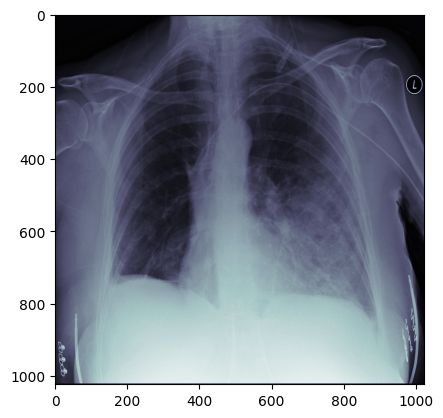

In [9]:
imgIndex = 2600
imgPath = trainingSetImageMetadata[imgIndex]
imgPath = imgPath.imagePath()
imgData = loadImage(imgPath)

pyplot.imshow(imgData.pixel_array, cmap = pyplot.cm.bone)

In [10]:
trainSetImageMetadata_df = pd.DataFrame(trainingSetImageMetadata, columns = ['Path'])

imageIdpaths = pd.DataFrame(columns = ['patientId', 'imgPath'])
imageIdpaths['patientId'] = trainSetImageMetadata_df['Path'].apply(getImgId)
imageIdpaths['imgPath'] = trainSetImageMetadata_df['Path']

print("Shape of the concerned dataset: ", imageIdpaths.shape)
print('The dataset looks as:\n')
imageIdpaths.head()


Shape of the concerned dataset:  (26684, 2)
The dataset looks as:



,patientId,imgPath
0,c3b05294-29be-46e4-8a51-96fd211e4ca5,/kaggle/input/rsna-pneumonia-detection-challen...
1,6a6ed2c5-d179-4c19-aac7-0d70eb87e024,/kaggle/input/rsna-pneumonia-detection-challen...
2,06550cfd-e9d5-415e-bae9-3146329ed9e6,/kaggle/input/rsna-pneumonia-detection-challen...
3,ef9eee29-6bdd-41da-ae40-9473592a9d5c,/kaggle/input/rsna-pneumonia-detection-challen...
4,c5dfc1a7-4669-42ce-af9f-62c3d8322049,/kaggle/input/rsna-pneumonia-detection-challen...


In [11]:
detailclass_df = pd.read_csv('../input/rsna-pneumonia-detection-challenge/stage_2_detailed_class_info.csv')
trainlabels_df = pd.read_csv('../input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv')

In [12]:
print('The detailed class dataframe has {} rows and {} columns and looks like:'.format(detailclass_df.shape[0], detailclass_df.shape[1]))
detailclass_df.head()

The detailed class dataframe has 30227 rows and 2 columns and looks like:


,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [13]:
print('The training label dataframe has {} rows and {} columns and looks like:'.format(trainlabels_df.shape[0], trainlabels_df.shape[1]))
trainlabels_df.head()

The training label dataframe has 30227 rows and 6 columns and looks like:


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


From our visualization task we know the following things:

* We have a total of 30227 records (in both of the files) and out of that 26684 are unique records, thus some patients having multiple entries in the file.
* There are two values in the "Target" column of the labels file: 0 suggesting No Pneumonia and 1 suggesting that the concerned patient does have Pneumonia.
* There are 20672 entries in the labels file where bounding box cordinates are not available, thus these belongs to the Patients not having Pneumonia.
*  There are 9555 entries where the coordinates are provided.
*  There are 3 Unique classes as observed from the class file: No Lung Opacity/Not Normal, Normal and Lung Opacity
acity

In [14]:
#sorting both the datasets based on patientId
trainlabels_df.sort_values('patientId', inplace = True)
detailclass_df.sort_values('patientId', inplace = True)

#concatenating the data
merge_data_df = pd.concat([trainlabels_df, detailclass_df['class']], axis = 1, sort = False)
print('The merged dataset has {} rows and {} columns and looks like:'.format(merge_data_df.shape[0], merge_data_df.shape[1]))
merge_data_df.head()

The merged dataset has 30227 rows and 7 columns and looks like:


,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
28989,000924cf-0f8d-42bd-9158-1af53881a557,NaN,NaN,NaN,NaN,0,Normal
28990,000db696-cf54-4385-b10b-6b16fbb3f985,316.0,318.0,170.0,478.0,1,Lung Opacity
28991,000db696-cf54-4385-b10b-6b16fbb3f985,660.0,375.0,146.0,402.0,1,Lung Opacity
28992,000fe35a-2649-43d4-b027-e67796d412e0,570.0,282.0,269.0,409.0,1,Lung Opacity


Both the dataframe has been merged to form a new dataset to have a much more detailed view. From this it is clear that Target with 0 corresponds either to "No Lung Opacity / Not Normal" or "Normal" and 1 with "Lung Opacity".

**Prepare data for Training**
* 
We will convert the dataset to have just two classes for our ease of doing
*  Going forward Target 0 will correspond to Normal class
*  whereas Target 1 will corresponds with Lung Opacity.

In [15]:
#convert the dataset into two classes only:
merge_data_df['class'].replace('No Lung Opacity / Not Normal', 'Normal', inplace = True)
print('The merge dataset now looks like:')
merge_data_df.head()

The merge dataset now looks like:


,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,Normal
28989,000924cf-0f8d-42bd-9158-1af53881a557,NaN,NaN,NaN,NaN,0,Normal
28990,000db696-cf54-4385-b10b-6b16fbb3f985,316.0,318.0,170.0,478.0,1,Lung Opacity
28991,000db696-cf54-4385-b10b-6b16fbb3f985,660.0,375.0,146.0,402.0,1,Lung Opacity
28992,000fe35a-2649-43d4-b027-e67796d412e0,570.0,282.0,269.0,409.0,1,Lung Opacity


**Splitting of the dataset**

We will split the merge_data_df to have three different datasets: train, validation and test.

In [16]:
train_mergedata = merge_data_df[0:15000]
validate_mergedata = merge_data_df[15000:25000]
test_mergedata = merge_data_df[25000:30227]

print('Shape of training data: ', train_mergedata.shape)
print('Shape of validation data: ', validate_mergedata.shape)
print('Shape of test data: ', test_mergedata.shape)



Shape of training data:  (15000, 7)
Shape of validation data:  (10000, 7)
Shape of test data:  (5227, 7)


Thus we have a training set with 15000 entries, validation set with 10000 entries and 5227 with test dataset.

We will replace the NaN values present in the dataset with 0 for our convenience.

In [17]:
#setting all NaN values to 0 in both the data sets
#x, y, width and hight values as zero(0) means no bounding box.
train_mergedata.fillna(0, inplace = True)
print('The training data now looks as: \n')
train_mergedata.head()

The training data now looks as: 



,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,0.0,0.0,0,Normal
28989,000924cf-0f8d-42bd-9158-1af53881a557,0.0,0.0,0.0,0.0,0,Normal
28990,000db696-cf54-4385-b10b-6b16fbb3f985,316.0,318.0,170.0,478.0,1,Lung Opacity
28991,000db696-cf54-4385-b10b-6b16fbb3f985,660.0,375.0,146.0,402.0,1,Lung Opacity
28992,000fe35a-2649-43d4-b027-e67796d412e0,570.0,282.0,269.0,409.0,1,Lung Opacity


In [18]:
validate_mergedata.fillna(0, inplace = True)
print('\nThe validation data now looks as:\n')
validate_mergedata.head


The validation data now looks as:



<bound method NDFrame.head of                                   patientId      x      y  width  height  \
13841  8a546535-613f-49b1-897c-a0933c53cb84   97.0  157.0  228.0   583.0   
13842  8a546535-613f-49b1-897c-a0933c53cb84  446.0  175.0  247.0   644.0   
13843  8a56a448-1214-4d0d-a6b2-d5e285d8742f    0.0    0.0    0.0     0.0   
13844  8a57180c-4321-475a-8448-8db41045c604    0.0    0.0    0.0     0.0   
13845  8a58d9e2-9cf1-405b-8e7e-102117a8200d    0.0    0.0    0.0     0.0   
...                                     ...    ...    ...    ...     ...   
23758  d5be0945-b546-4640-b0a0-d2dd209122e8  654.0  409.0  125.0   178.0   
23757  d5be0945-b546-4640-b0a0-d2dd209122e8  178.0  469.0  185.0   113.0   
23759  d5bf0dbb-c132-42b8-9ed7-4188d0698fd9    0.0    0.0    0.0     0.0   
23760  d5c0eb30-b101-4bcc-a8c0-f08675b45efa    0.0    0.0    0.0     0.0   
23761  d5cbd64c-322b-4460-ad0e-c9a23e781f3e  714.0  290.0  105.0   276.0   

       Target         class  
13841       1  Lung Opacity

In [19]:
test_mergedata.fillna(0, inplace = True)
print('The test data now looks as:')
test_mergedata.head()

The test data now looks as:


,patientId,x,y,width,height,Target,class
23762,d5d0be71-4579-411a-9218-0f45a80df505,0.0,0.0,0.0,0.0,0,Normal
23763,d5d46405-ff85-46fa-9c3b-2c21ad366f76,709.0,534.0,96.0,65.0,1,Lung Opacity
23764,d5d6f7e3-5143-4955-901e-cad92024fee0,0.0,0.0,0.0,0.0,0,Normal
23765,d5d7c95e-0682-4b93-bf0b-5dff2fa91a92,215.0,221.0,188.0,253.0,1,Lung Opacity
23766,d5d7c95e-0682-4b93-bf0b-5dff2fa91a92,594.0,256.0,230.0,176.0,1,Lung Opacity


In [20]:
print("Number of unique patients in training dataset: ", train_mergedata["patientId"].nunique())
print("Number of unique patients in validation dataset: ", validate_mergedata["patientId"].nunique())
print("Number of unique patients in test dataset: ", test_mergedata["patientId"].nunique())

Number of unique patients in training dataset:  13163
Number of unique patients in validation dataset:  8601
Number of unique patients in test dataset:  4920


In [21]:
imageIdpaths.sort_values('patientId', inplace = True)


train_imageIdpaths = imageIdpaths[0:13163]
validate_imageIdpaths = imageIdpaths[13163:21764]
test_imageIdpaths = imageIdpaths[21764:26684]

print('Shape of training dataframe having patientId and image paths: ', train_imageIdpaths.shape)
print('Shape of validation dataframe having patientId and image paths: ', validate_imageIdpaths.shape)
print('Shape of test dataframe having patientId and image paths: ', test_imageIdpaths.shape)

Shape of training dataframe having patientId and image paths:  (13163, 2)
Shape of validation dataframe having patientId and image paths:  (8601, 2)
Shape of test dataframe having patientId and image paths:  (4920, 2)


<Axes: xlabel='Target', ylabel='count'>

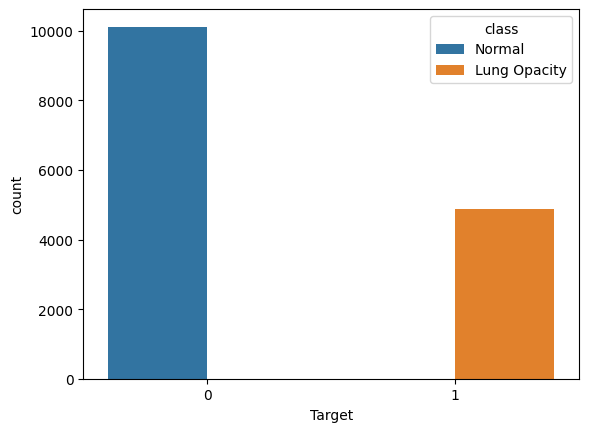

In [22]:
sns.countplot(x = 'Target', hue = 'class', data = train_mergedata)

<Axes: xlabel='Target', ylabel='count'>

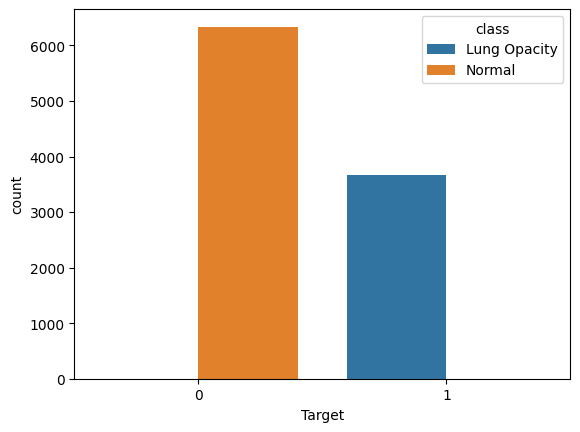

In [23]:
sns.countplot(x = 'Target', hue = 'class', data = validate_mergedata)

<Axes: xlabel='Target', ylabel='count'>

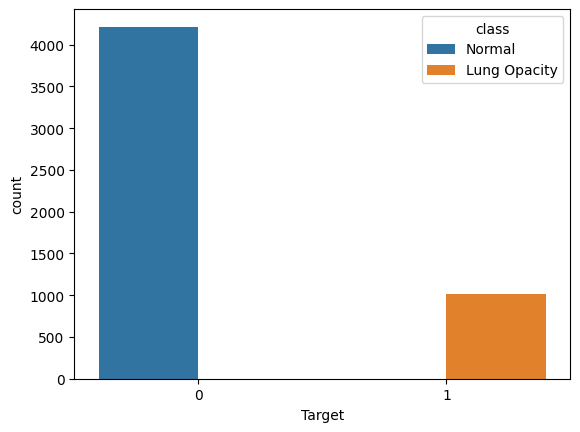

In [24]:
sns.countplot(x = 'Target', hue = 'class', data = test_mergedata)

# Functions and Class Definitions
Here we will define some of the functions that will help us in creating a model

 * **Loss and Metric Functions**
   We will be using "Jaccard Loss Function" as the loss function and "Mean IOU" to measure the efficiency of the model.
del.

In [25]:
# define iou or jaccard loss function
def iou_loss(y_true, y_pred):
    """
    Arguments:
        y_true -- ground truth mask 
        y_pred -- predicted mask
    """
    
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# # mean iou as a metric
# def mean_iou(y_true, y_pred):
#     """
#     Arguments:
#         y_true -- ground truth mask
#         y_pred -- predicted mask
#     """
    
#     y_pred = tf.round(y_pred)    
#     intersect = tf.reduce_sum(y_true * y_pred, axis = [1]) 
#     union = tf.reduce_sum(y_true, axis = [1]) + tf.reduce_sum(y_pred, axis = [1])
#     smooth = tf.ones(tf.shape(intersect))
#     return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))


def mean_iou(y_true, y_pred):
    """
    Arguments:
        y_true -- ground truth mask
        y_pred -- predicted mask
    """
    # Ensure y_true has the same shape and type as y_pred
    y_true = tf.cast(y_true, tf.float32)  # Convert y_true to float32 for consistency
    y_pred = tf.cast(y_pred, tf.float32)  # Convert y_pred to float32 for consistency
    
    # Expand dimensions of y_true to match the shape of y_pred (if needed)
    if len(y_true.shape) < len(y_pred.shape):
        y_true = tf.expand_dims(y_true, axis=-1)  # Add the channel dimension to y_true if missing
    
    # Round the predictions to get binary values
    y_pred = tf.round(y_pred)
    
    # Calculate intersection and union
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2])  # Sum over spatial dimensions (height and width)
    union = tf.reduce_sum(y_true, axis=[1, 2]) + tf.reduce_sum(y_pred, axis=[1, 2])

    # Add a smoothing term to avoid division by zero
    smooth = tf.ones_like(intersect, dtype=tf.float32)  # Ensure smooth is float32 to match other tensors
    
    # Return the mean IoU
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))



* Function to obtain Intersection Over Union (IoU) ratio from Ground Truth and Predicted Box Coordinates

In [26]:
def iouFromCoords(boxA, boxB) :
    """
    Arguments:
        boxA -- ground truth mask
        boxB -- predicted mask
    """
    
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    intersectionArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
    if intersectionArea == 0:
        return 0
    
    # compute the area of both the prediction and ground-truth rectangles
    boxAArea = abs((boxA[2] - boxA[0]) * (boxA[3] - boxA[1]))
    boxBArea = abs((boxB[2] - boxB[0]) * (boxB[3] - boxB[1]))

    # compute the intersection over union
    iou = intersectionArea / float(boxAArea + boxBArea - intersectionArea)

    # return the intersection over union value
    return iou

* Function to display the image with an imposing mask

In [27]:
def showMaskedImage(_imageSet, _maskSet, _index) :
    """
    Arguments:
        _imageSet -- set of images 
        _maskSet -- set of masks
        _index -- index of a set/collection
    """
    
    maskImage = _imageSet[_index]

    maskImage[:,:,0] = _maskSet[_index] * _imageSet[_index][:,:,0]
    maskImage[:,:,1] = _maskSet[_index] * _imageSet[_index][:,:,1]
    maskImage[:,:,2] = _maskSet[_index] * _imageSet[_index][:,:,2]

    pyplot.imshow(maskImage[:,:,0], cmap=pyplot.cm.bone)

* Some basic variables are defined which will be used

In [29]:
image_size = 224
img_width = 1024
img_height = 1024

train_batch_size = 32
test_batch_size = 32

* A class is being defined to get data batch for training the model


In [30]:
#Generator class to get data batch for training the model. It extends the Sequence class
class UNetTrainGenerator(Sequence):
    """
    Arguments:
        _imgaeIdpaths: dataframe having patientIds and image paths to load the image
        _mergedata: dataframe having patientId, bounding box coordinates, target and class
        idx: index of the batch
    """
    
    def __init__(self, _imageIdPaths, _mergedata):
        self.pids = _mergedata['patientId'].to_numpy()
        self.imgIdPaths = _imageIdPaths
        self.coords = _mergedata[["x", "y", "width", "height"]].to_numpy()
        self.coords = self.coords * image_size / img_width
        
    def __len__(self):
        return math.ceil(len(self.coords) / train_batch_size)
    
    def __getitem__(self, idx):
        batch_coords = self.coords[idx * train_batch_size:(idx + 1) * train_batch_size] #image coords
        batch_pids = self.pids[idx * train_batch_size:(idx + 1) * train_batch_size] #image pids
        
        batch_images = np.zeros((len(batch_pids), image_size, image_size, 3), dtype = np.float32)
        batch_masks = np.zeros((len(batch_pids), image_size, image_size))
        
        for _indx, _pid in enumerate(batch_pids):
            _path = self.imgIdPaths[self.imgIdPaths["patientId"] == _pid]['imgPath'].array[0]
            _imgData = loadImage(str(_path))
            img = _imgData.pixel_array
            
            resized_image = cv2.resize(img, (image_size, image_size), interpolation = cv2.INTER_AREA)
            
            #preprocess image
            batch_images[_indx][:,:,0] = preprocess_input(np.array(resized_image[:,:], dtype = np.float32))
            batch_images[_indx][:,:,1] = preprocess_input(np.array(resized_image[:,:], dtype = np.float32))
            batch_images[_indx][:,:,2] = preprocess_input(np.array(resized_image[:,:], dtype = np.float32))
            
            x = int(batch_coords[_indx, 0])
            y = int(batch_coords[_indx, 1])
            width = int(batch_coords[_indx, 2]) 
            height = int(batch_coords[_indx, 3])
            
            batch_masks[_indx][y:y+height, x:x+height] = 1
        
        return batch_images, batch_masks



In [31]:
train_generator = UNetTrainGenerator(_imageIdPaths=imageIdpaths, _mergedata=train_mergedata)
# Fetching a single batch for testing
batch_images, batch_masks = train_generator[1]

# Check the outputs
print("Batch Images Shape:", batch_images.shape)
print("Batch Masks Shape:", batch_masks.shape)


Batch Images Shape: (32, 224, 224, 3)
Batch Masks Shape: (32, 224, 224)


* This class **UNetTrainGenerator** will help to load the training and validation data into the memory.

* A class is being defined to get data batch for testing

In [32]:
#Generator to Predict the model
class UNetTestGenerator(Sequence):
    """        
    Arguments:
        _imageIdPaths: dataframe having patientId and image paths to load image
        _mergedata: dataframe having patientId, bounding box coordinates, target and class      
        idx -- index of a batch
    """
    
    def __init__(self, _imageIdPaths, _mergedata):       
        self.pids = _mergedata["patientId"].to_numpy()
        self.imgIdPaths = _imageIdPaths
        self.coords = _mergedata[["x", "y", "width", "height", "Target"]].to_numpy()
        self.classes = _mergedata["class"]
        # Resize Bounding box
        self.coordsOrig = self.coords
        self.coords = self.coords * image_size / img_width           

    def __len__(self):
        # Returns total number of batches
        return math.ceil(len(self.coords) / test_batch_size)
    

    def __getitem__(self, idx):
        batch_coords = self.coords[idx * test_batch_size:(idx + 1) * test_batch_size]
        batch_coordsOrig = self.coordsOrig[idx * test_batch_size:(idx + 1) * test_batch_size]
        batch_pids = self.pids[idx * test_batch_size:(idx + 1) * test_batch_size]    
        batch_classes = self.classes[idx * test_batch_size:(idx + 1) * test_batch_size]           
        if len(batch_pids) == 0:
            raise StopIteration     
        batch_images = np.zeros((len(batch_pids), image_size, image_size, 3), dtype=np.float32)
        batch_masks = np.zeros((len(batch_pids), image_size, image_size))
        for _indx, _pid in enumerate(batch_pids):
            _path = self.imgIdPaths[self.imgIdPaths["patientId"] == _pid]["imgPath"].array[0]
            _imgData = loadImage(str(_path))
            img = _imgData.pixel_array 
            
            # Resize image
            resized_img = cv2.resize(img, (image_size, image_size), interpolation=cv2.INTER_AREA)
            # preprocess image for the batch
            batch_images[_indx][:,:,0] = preprocess_input(np.array(resized_img[:,:], dtype=np.float32))
            batch_images[_indx][:,:,1] = preprocess_input(np.array(resized_img[:,:], dtype=np.float32))
            batch_images[_indx][:,:,2] = preprocess_input(np.array(resized_img[:,:], dtype=np.float32))  
            
            x = int(batch_coords[_indx, 0])
            y = int(batch_coords[_indx, 1])
            width = int(batch_coords[_indx, 2])
            height = int(batch_coords[_indx, 3])
            target = int(batch_coords[_indx, 4])
            
            batch_coords[_indx, 0] = x
            batch_coords[_indx, 1] = y 
            batch_coords[_indx, 2] = width 
            batch_coords[_indx, 3] = height    
            batch_coords[_indx, 4] = target 
            
            batch_masks[_indx][y:y+height, x:x+width] = 1

        # Returns images, ground truth masks, patientIds, resized-coordinates, class targets and ground truth coordinates/lables.   
        return batch_images, batch_masks, batch_pids, batch_coords, batch_classes, batch_coordsOrig

    
    

In [33]:
test_generator = UNetTestGenerator(_imageIdPaths=imageIdpaths, _mergedata=train_mergedata
                                  )
batch_images1, batch_masks1, _, _, _, _ = test_generator[1]


# Check the outputs
print("Batch Images Shape:", batch_images1.shape)
print("Batch Masks Shape:", batch_masks1.shape)


Batch Images Shape: (32, 224, 224, 3)
Batch Masks Shape: (32, 224, 224)


* The above defined class UNetTestGenerator will help to load the test data.

# Creating functions for Model Architecture

ResNet50

In [34]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Concatenate, UpSampling2D,Conv2D,Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential

model=ResNet50()
def ResNet_model():
  model = Sequential()
  model = ResNet50()
  for layer in model.layers[:-10]:
      layer.trainable = True


  block1 = model.get_layer("conv1_relu").output
  block2 = model.get_layer("conv2_block3_out").output
  block3 = model.get_layer("conv3_block4_out").output
  block4 = model.get_layer("conv4_block6_out").output
  block5 = model.get_layer("conv5_block3_out").output
  
  
  x = Concatenate()([UpSampling2D()(block5), block4])
  x = Conv2D(100, (1, 1), activation='relu') (x)
  x = Concatenate()([UpSampling2D()(x), block3])
  x = Conv2D(100, (1, 1), activation='relu') (x)
  x = Concatenate()([UpSampling2D()(x), block2])
  x = Conv2D(100, (1, 1), activation='relu') (x)
  x = Concatenate()([UpSampling2D()(x), block1])
  x = Conv2D(100, (1, 1), activation='relu') (x)
  x = UpSampling2D()(x)
  x = Conv2D(1, kernel_size=1,strides=1, activation="sigmoid")(x)
  x = Reshape((224, 224,1))(x)

  return Model(inputs=model.input, outputs=x)

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


**UNet with MobileNet**
It is based on the one on which we made our previous submission.

In [35]:
#Function to create UNet architecture with MobileNet
def create_UNetModel(trainable=True):
    """        
    Arguments:
        trainable: Flag to make layers trainable. Default value is 'True'.
    """
    # Get all layers with 'imagenet' weights
    model = MobileNet(input_shape = (image_size, image_size, 3), include_top=False,
                      alpha = 1.0, weights="imagenet") 
    # Top layer is last layer of the model
    
    # Make all layers trainable
    for layer in model.layers:
        layer.trainable = trainable

    # Add all the UNET layers here
    convLayer_112by112 = model.get_layer("conv_pw_1_relu").output
    convLayer_56by56 = model.get_layer("conv_pw_3_relu").output
    convLayer_28by28 = model.get_layer("conv_pw_5_relu").output
    convLayer_14by14 = model.get_layer("conv_pw_11_relu").output
    convLayer_7by7 = model.get_layer("conv_pw_13_relu").output
    # The last layer of mobilenet model is of dimensions (7x7x1024)
    # Steps to upsample from 7x7 to 14x14..upto 224x224 to form UNET
    x = Concatenate()([UpSampling2D()(convLayer_7by7), convLayer_14by14])
    x = Concatenate()([UpSampling2D()(x), convLayer_28by28])
    x = Concatenate()([UpSampling2D()(x), convLayer_56by56])
    x = Concatenate()([UpSampling2D()(x), convLayer_112by112])
    x = UpSampling2D(name="unet_last")(x) # upsample to 224x224

    # Add classification layer
    x = Conv2D(1, kernel_size=1, activation="sigmoid", name="masks")(x)
    x = Reshape((image_size, image_size))(x) 

    return Model(inputs=model.input, outputs=x)

* UNet with ResNet50

In [36]:
def conv_block_simple(prevlayer, filters, prefix, strides=(1, 1)):
    """       
    Arguments:
        prevlayer: previous layer of the convolution block
        
        filters: number of filters for convolution
        
        prefix: prefix for the layer name
        
        strides: convolution stride. Default is 1x1.
    """
    conv = Conv2D(filters, (3, 3), padding="same", kernel_initializer="he_normal", strides=strides, name=prefix + "_conv")(prevlayer)
    conv = BatchNormalization(name=prefix + "_bn")(conv)
    conv = Activation('relu', name=prefix + "_activation")(conv)
    
    # Returns the built layers of the block.
    return conv

In [37]:
def create_ResNetUNetModel(trainable=True):
    """        
    Arguments:
        trainable: Flag to make layers trainable. Default value is 'True'.
    """
    resnetLayers = ResNet50(weights='imagenet', input_shape=(image_size, image_size, 3),
                            include_top=False) # Load pre-trained Resnet

    for layer in resnetLayers.layers:
        layer.trainable = trainable

    # Add all the UNet layers here
    convLayer_112by112 = resnetLayers.get_layer("conv1_relu").output
    convLayer_56by56 = resnetLayers.get_layer("conv2_block3_out").output
    convLayer_28by28 = resnetLayers.get_layer("conv3_block4_out").output
    convLayer_14by14 = resnetLayers.get_layer("conv4_block6_out").output
    convLayer_7by7 = resnetLayers.get_layer("conv5_block3_out").output
    # The last layer of resnet model(conv5_block3_out) is of dimensions (7x7x2048)

    # Start upsampling from 7x7 to 14x14 ...up to 224x224 to form UNet
    up14by14 = Concatenate()([UpSampling2D()(convLayer_7by7), convLayer_14by14])
    upConvLayer_14by14 = conv_block_simple(up14by14, 256, "upConvLayer_14by14_1")
    upConvLayer_14by14 = conv_block_simple(upConvLayer_14by14, 256, "upConvLayer_14by14_2")
    
    up28by28 = Concatenate()([UpSampling2D()(upConvLayer_14by14), convLayer_28by28])
    upConvLayer_28by28 = conv_block_simple(up28by28, 256, "upConvLayer_28by28_1")
    upConvLayer_28by28 = conv_block_simple(upConvLayer_28by28, 256, "upConvLayer_28by28_2")
     
    up56by56 = Concatenate()([UpSampling2D()(upConvLayer_28by28), convLayer_56by56])
    upConvLayer_56by56 = conv_block_simple(up56by56, 256, "upConvLayer_56by56_1")
    upConvLayer_56by56 = conv_block_simple(upConvLayer_56by56, 256, "upConvLayer_56by56_2")    
    
    up112by112 = Concatenate()([UpSampling2D()(upConvLayer_56by56), convLayer_112by112])
    upConvLayer_112by112 = conv_block_simple(up112by112, 256, "upConvLayer_112by112_1")
    upConvLayer_112by112 = conv_block_simple(upConvLayer_112by112, 256, "upConvLayer_112by112_2")   
    
    up224by224 = UpSampling2D(name="unet_last")(upConvLayer_112by112) # upsample to 224x224
    upConvLayer_224by224 = conv_block_simple(up224by224, 256, "upConvLayer_224by224_1")
    upConvLayer_224by224 = conv_block_simple(upConvLayer_224by224, 256, "upConvLayer_224by224_2")   

    # Add classification layer
    upConvLayer_224by224 = Conv2D(1, kernel_size=1, activation="sigmoid", name="masks")(upConvLayer_224by224)
    upConvLayer_224by224 = Reshape((image_size, image_size))(upConvLayer_224by224) 

    return Model(inputs=resnetLayers.input, outputs=upConvLayer_224by224)

# Some more necessary functions
Function to create Confusion Matrix and Classification Report

In [38]:
def showConfusionMatrix(IOU_report) :
    """   
    Arguments:
        IOU_report: dataframe having target and prediction columns.
    """
    
    IOU_report.fillna(0, inplace=True)
    
    # Get Targets and Predictions
    y_IOU_test = IOU_report["Target"]
    y_IOU_predicted = IOU_report["predTarget"]
    print("Predictions in terms of IOU :\n")
    print("Confusion Matrix:\n", metrics.confusion_matrix(y_IOU_test, y_IOU_predicted))
    print("\nClassification Report:\n", metrics.classification_report(y_IOU_test, y_IOU_predicted))

* Function to predict test data set and save the submission report into a csv file

In [39]:
def predictBatches(_test_mergedata, _test_imageIdpaths, _UNetModel):
    """        
    Arguments:
        _test_mergedata: DataFrame containing patientId, bounding box coordinates, target, and class for test samples.
        _test_imageIdpaths: DataFrame containing patientId and image paths for loading test images.
        _UNetModel: Pre-trained UNet model used for predicting test data.
    """
    
    print('Number of Test Samples:', _test_mergedata["patientId"].nunique())
    
    # Create test generator instance
    testUNetDataGen = UNetTestGenerator(_test_imageIdpaths, _test_mergedata)
    
    # Initialize submission DataFrame
    submissionDF = pd.DataFrame(columns=[
        'patientId', 'x', 'y', 'width', 'height', 'Target', 'class', 
        'x_pred', 'y_pred', 'width_pred', 'height_pred', 'predTarget', 'iou', 'class_pred'
    ])
    dfIndex = 0
    iouThreshold = 0.3  # IoU threshold of 30%

    print("Predicting Batches ", end='')
    for batchImages, gtBatchMasks, batchPids, batchCoords, batchClasses, batchCoordsOrig in testUNetDataGen:
        try:
            print("Batch images shape:", batchImages.shape)
            # Predict batch of images
            batchPreds = _UNetModel.predict(batchImages, verbose=0)

            prevPid = ""
            # Loop through batch
            for pred, gtMask, pid, coords, gtClass, coordsOrig in zip(
                batchPreds, gtBatchMasks, batchPids, batchCoords, batchClasses, batchCoordsOrig
            ):
                if prevPid != pid:
                    prevPid = pid

                    # Resize predicted mask
                    pred = resize(pred, (1024, 1024), mode='reflect')
                    coords = coordsOrig  # Recompute coords for resized prediction

                    # Threshold predicted mask
                    strongPred = pred[:, :] > 0.5
                    strongPred = measure.label(strongPred)

                    iouCoordsDF = pd.DataFrame(columns=['iou', 'x', 'y', 'width', 'height'])
                    for region in measure.regionprops(strongPred):
                        y, x, _, y2, x2, _ = region.bbox
                        height = y2 - y
                        width = x2 - x

                        # Get IoU
                        coordsXYs = np.array([coords[0], coords[1], coords[2] + coords[0], coords[3] + coords[1]])
                        regionXYs = np.array([x, y, x2, y2])
                        IOU = iouFromCoords(coordsXYs, regionXYs)
                        iouCoordsDF.loc[len(iouCoordsDF)] = [IOU, x, y, width, height]

                    GTDFRow = [pid, coords[0], coords[1], coords[2], coords[3], coords[4], gtClass]
                    prevGTDFRow = []

                    # Get top 2 predictions based on IoU
                    iouCoordsDF.sort_values("iou", ascending=False, inplace=True)
                    predIOUCoordCount = 0

                    if len(iouCoordsDF) > 0:
                        for predIOUCoordIdx in range(len(iouCoordsDF)):
                            if iouCoordsDF.iloc[predIOUCoordIdx]["iou"] > iouThreshold:
                                submissionDFRow = [
                                    pid, coords[0], coords[1], coords[2], coords[3], coords[4], 
                                    gtClass, int(iouCoordsDF.iloc[predIOUCoordIdx]["x"]), 
                                    int(iouCoordsDF.iloc[predIOUCoordIdx]["y"]), 
                                    int(iouCoordsDF.iloc[predIOUCoordIdx]["width"]), 
                                    int(iouCoordsDF.iloc[predIOUCoordIdx]["height"]), 
                                    1, iouCoordsDF.iloc[predIOUCoordIdx]["iou"], "Lung Opacity"
                                ]
                                if predIOUCoordCount < 2 and GTDFRow != prevGTDFRow:
                                    submissionDF.loc[dfIndex] = submissionDFRow
                                    dfIndex += 1
                                    predIOUCoordCount += 1
                                    prevGTDFRow = GTDFRow
                            else:
                                if GTDFRow != prevGTDFRow:
                                    submissionDFRow = [
                                        pid, coords[0], coords[1], coords[2], coords[3], coords[4], 
                                        gtClass, 0, 0, 0, 0, 0, 
                                        iouCoordsDF.iloc[predIOUCoordIdx]["iou"], "Normal"
                                    ]
                                    submissionDF.loc[dfIndex] = submissionDFRow
                                    dfIndex += 1
                                    prevGTDFRow = GTDFRow
                                    break
                    else:
                        submissionDFRow = [
                            pid, coords[0], coords[1], coords[2], coords[3], coords[4], 
                            gtClass, 0, 0, 0, 0, 0, 'NA', "Normal"
                        ]
                        submissionDF.loc[dfIndex] = submissionDFRow
                        dfIndex += 1

        except Exception as e:
            print(f"Error encountered in batch: {e}")
            continue

    # Save submission data to CSV
    submissionDF.to_csv('submission.csv', index=False)
    print("Prediction Complete!")
    
    test_y = submissionDF["Target"]
    predicted_y = submissionDF["predTarget"]
    
    return test_y.apply(int), predicted_y.apply(int)


* Function to visualize predictions by displaying the ground truth and predicted bounding box

In [40]:
def visualizePredictions(_predReportDF, _topNum) :
    """        
    Arguments:
        _predReportDF: dataframe having patientId, IoUs, target and prediction coordinate columns.
        _topNum -- number indicating the count of top predictions to be visualized.
    """
    # Sort on IOU to get higher IOUs on top
    _predReportDF.sort_values("iou", ascending=False, inplace=True)
    # Get patientIds
    topPids = _predReportDF["patientId"].head(_topNum)
    topPidsAry = np.array(topPids)
    # Get IOUs
    topIOUs = _predReportDF["iou"].head(_topNum)
    topIOUsAry = np.array(topIOUs)

    # To get ground truth images for top IOU scored pids
    imageCollc = np.zeros((_topNum, img_width, img_height), np.float32)

    # Get ground truth coordinates for top IOU scored rows and prepare masks
    gtCoordCollc = _predReportDF[["x", "y", "width", "height"]].to_numpy()
    # To get ground truth masks
    gtMaskCollc  = np.zeros((_topNum, img_width, img_height), int)

    # Get ground truth coordinates for top IOU scored rows and prepare masks
    predCoordCollc = _predReportDF[["x_pred", "y_pred", "width_pred", "height_pred"]].to_numpy()  # (1024, 1024)
    # To get ground truth masks
    predMaskCollc  = np.zeros((_topNum, img_width, img_height), int)

    # Get ground truth and prediction masks
    for indx in range(0, _topNum) :
        # Get images
        path = test_imageIdpaths[test_imageIdpaths["patientId"] == topPidsAry[indx]]["imgPath"].array[0]
        imgData = loadImage(str(path)) # Read image
        img = imgData.pixel_array
        imageCollc[indx][:,:] = preprocess_input(np.array(img[:,:], dtype=np.float32)) # Convert to float32 array

        # prepare ground truth masks
        x = int(gtCoordCollc[indx, 0])
        y = int(gtCoordCollc[indx, 1])
        width = int(gtCoordCollc[indx, 2])
        height = int(gtCoordCollc[indx, 3])
        gtMaskCollc[indx][y:y+height, x:x+width] = 1   # (1024, 1024)

        # prepare predicted masks
        x_pred = int(predCoordCollc[indx, 0])
        y_pred = int(predCoordCollc[indx, 1])
        width_pred = int(predCoordCollc[indx, 2])
        height_pred = int(predCoordCollc[indx, 3])
        predMaskCollc[indx][y_pred:y_pred+height_pred, x_pred:x_pred+width_pred] = 1   # (1024, 1024)
        
    # Show images and bounding boxes
    imageArea, axesArry = pyplot.subplots(int(_topNum/2), 2, figsize=(18,18))
    axesArry = axesArry.ravel()
    for axidx in range(0, _topNum) :
        axesArry[axidx].imshow(imageCollc[axidx][:, :], cmap=pyplot.cm.bone)

        gtComp = gtMaskCollc[axidx][:, :] > 0.5
        # apply connected components
        gtComp = measure.label(gtComp)
        # apply ground truth bounding boxes
        for region in measure.regionprops(gtComp):
            # retrieve x, y, height and width
            y1, x1, y2, x2 = region.bbox
            heightReg = y2 - y1
            widthReg = x2 - x1
            axesArry[axidx].add_patch(patches.Rectangle((x1, y1), widthReg, heightReg, linewidth=1, edgecolor='r', 
                                                        facecolor='none'))

        predComp = predMaskCollc[axidx][:, :] > 0.5
        # apply connected components
        predComp = measure.label(predComp)
        # apply predicted bounding boxes
        for region_pred in measure.regionprops(predComp):
            # retrieve x, y, height and width
            y1_pred, x1_pred, y2_pred, x2_pred = region_pred.bbox
            heightReg_pred = y2_pred - y1_pred
            widthReg_pred = x2_pred - x1_pred
            axesArry[axidx].add_patch(patches.Rectangle((x1_pred, y1_pred), widthReg_pred, heightReg_pred, linewidth=1, edgecolor='b', 
                                                        facecolor='none'))
            axesArry[axidx].set_title('IOU : '+str(topIOUsAry[axidx]))
    # Show subplots
    pyplot.show()

**Create Generator instances for Train and Validation datasets**

In [41]:
trainUNet = UNetTrainGenerator(train_imageIdpaths, train_mergedata)
validateUNet = UNetTrainGenerator(validate_imageIdpaths, validate_mergedata)

# Training model
ResNet50

In [ ]:
model=ResNet_model()
model.summary()

The above model will have a total of 24,008, 613 params. Out of which we have 23,955,493 params as trainable params

In [ ]:
def cosine_annealing(x):
    lr = 0.001
    epochs = 10
    return lr*(np.cos(np.pi * x/epochs) + 1.) / 2



In [ ]:
adamopt_r = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model again with the new optimizer
model.compile(optimizer=adamopt_r, loss=iou_loss, metrics=[mean_iou])

learning_rate = LearningRateScheduler(cosine_annealing)
stop = EarlyStopping(monitor = 'loss', mode = 'min', patience = 3)

checkpoint_or = ModelCheckpoint("onlyres-{epoch:02d}-{val_mean_iou:.2f}.weights.h5", monitor = 'loss',
                             verbose = 1, mode = 'min', save_best_only = True,
                             save_weights_only = True)

history_ures = model.fit(trainUNet, epochs = 10,
                                   validation_data = validateUNet,
                                   callbacks = [learning_rate, checkpoint_or, stop],
                                   shuffle = True, verbose = 1)

In [ ]:
ls

In [ ]:
model.load_weights('onlyres-10-0.65.weights.h5')

In [ ]:
y_test, y_predicted = predictBatches(test_mergedata, test_imageIdpaths, model)

In [ ]:
report_file_res = pd.read_csv('./submission.csv')
showConfusionMatrix(report_file_res)

Analysis from the Confusion Matrix:

* True Positives(TP) - 148 cases which is a point of concern. Thus, our model failed in successfully predicting the cases of Pneumonia pr cases with Lung Opacity
* True Negatives(TN) - 4214 patients who have actually 'No Lung Opacity'/'Normal' are correctly predicted as 'Normal' or cases with no Pneumonia
* False Positives(FP) - 0 cases who have actually 'No Lung Opacity'/'Normal' incorrectly predicted as having 'Lung Opacity'. This means there are no model mistakes in identifying 'Normal' as 'Lung Opacity'. Type-I error is zero. This is a big positive point for a medical test
* (FN) are - 559 cases where the patients who have actually 'Lung Opacity' or 'Pneumonia' are incorrectly predicted as'Normal'. These are model mistakes.Thus, we need to seek some other architecture.
cture.

In [ ]:
import pandas as pd

# Load the CSV to inspect its structure
df = pd.read_csv('./submission.csv')

# Display the column names
print("Column names:", df.columns)

# Display the first few rows to check the data
print(df.head())


In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv('./submission.csv')

# Extract the actual labels (Target) and predicted labels (predTarget)
y_true = df['Target']  # Actual labels
y_pred = df['predTarget']  # Predicted labels

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix using seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Predicted Normal', 'Predicted Lung Opacity'], 
            yticklabels=['Actual Normal', 'Actual Lung Opacity'])

# Adding labels and title to the plot
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [ ]:
UNet_MobileNet_Model = create_UNetModel()
print(UNet_MobileNet_Model.summary())

Thus, UNet with MobileNet has a total of 3,230,849 parameters. Out of which 3,208,961 parameters are trainable and the rest are non-trainable

Using Adam optimizer and Compliling the model

In [ ]:
import tensorflow as tf

# Enable memory growth for GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


In [ ]:

from tensorflow.keras.mixed_precision import set_global_policy

# Set the policy to mixed_float16
set_global_policy('mixed_float16')


# Rebuild the model with mixed precision enabled
UNet_MobileNet_Model = create_UNetModel()
# Create the Adam optimizer with updated parameters
adamopt = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)

# Compile the model
UNet_MobileNet_Model.compile(optimizer=adamopt, loss=iou_loss, metrics=[mean_iou])


In [ ]:
def cosine_annealing(x):
    lr = 0.001
    epochs = 10
    return lr*(np.cos(np.pi * x/epochs) + 1.) / 2

In [ ]:
learning_rate = LearningRateScheduler(cosine_annealing)
checkpoint = ModelCheckpoint("umobile-{epoch:02d}-{val_mean_iou:.2f}.weights.h5", 
                              monitor='loss', 
                              verbose=1, 
                              mode='min', 
                              save_best_only=True, 
                              save_weights_only=True)

stop = EarlyStopping(monitor = 'loss', mode = 'min', patience = 3)

In [ ]:
history_umobile = UNet_MobileNet_Model.fit(trainUNet, epochs = 5,batch_size=1,
                                                    validation_data = validateUNet,
                                                    callbacks = [learning_rate, checkpoint, stop],
                                                    shuffle = True, verbose = 1)

In [ ]:
ls

In [ ]:
UNet_MobileNet_Model.load_weights('umobile-05-0.64.weights.h5')

In [ ]:
def predictBatches1(_test_mergedata, _test_imageIdpaths, _UNetModel):
    """        
    Arguments:
        _test_mergedata: DataFrame containing patientId, bounding box coordinates, target, and class for test samples.
        _test_imageIdpaths: DataFrame containing patientId and image paths for loading test images.
        _UNetModel: Pre-trained UNet model used for predicting test data.
    """
    
    print('Number of Test Samples:', _test_mergedata["patientId"].nunique())
    
    # Create test generator instance
    testUNetDataGen = UNetTestGenerator(_test_imageIdpaths, _test_mergedata)
    
    # Initialize submission DataFrame
    submissionDF = pd.DataFrame(columns=[
        'patientId', 'x', 'y', 'width', 'height', 'Target', 'class', 
        'x_pred', 'y_pred', 'width_pred', 'height_pred', 'predTarget', 'iou', 'class_pred'
    ])
    dfIndex = 0
    iouThreshold = 0.3  # IoU threshold of 30%

    print("Predicting Batches ", end='')
    for batchImages, gtBatchMasks, batchPids, batchCoords, batchClasses, batchCoordsOrig in testUNetDataGen:
        try:
            print("Batch images shape:", batchImages.shape)
            # Predict batch of images
            batchPreds = _UNetModel.predict(batchImages, verbose=0)

            prevPid = ""
            # Loop through batch
            for pred, gtMask, pid, coords, gtClass, coordsOrig in zip(
                batchPreds, gtBatchMasks, batchPids, batchCoords, batchClasses, batchCoordsOrig
            ):
                if prevPid != pid:
                    prevPid = pid

                    # Resize predicted mask
                    pred = resize(pred, (1024, 1024), mode='reflect')
                    coords = coordsOrig  # Recompute coords for resized prediction

                    # Threshold predicted mask
                    strongPred = pred[:, :] > 0.5
                    strongPred = measure.label(strongPred)

                    iouCoordsDF = pd.DataFrame(columns=['iou', 'x', 'y', 'width', 'height'])
                    for region in measure.regionprops(strongPred):
                        y, x,  y2, x2 = region.bbox
                        height = y2 - y
                        width = x2 - x

                        # Get IoU
                        coordsXYs = np.array([coords[0], coords[1], coords[2] + coords[0], coords[3] + coords[1]])
                        regionXYs = np.array([x, y, x2, y2])
                        IOU = iouFromCoords(coordsXYs, regionXYs)
                        iouCoordsDF.loc[len(iouCoordsDF)] = [IOU, x, y, width, height]

                    GTDFRow = [pid, coords[0], coords[1], coords[2], coords[3], coords[4], gtClass]
                    prevGTDFRow = []

                    # Get top 2 predictions based on IoU
                    iouCoordsDF.sort_values("iou", ascending=False, inplace=True)
                    predIOUCoordCount = 0

                    if len(iouCoordsDF) > 0:
                        for predIOUCoordIdx in range(len(iouCoordsDF)):
                            if iouCoordsDF.iloc[predIOUCoordIdx]["iou"] > iouThreshold:
                                submissionDFRow = [
                                    pid, coords[0], coords[1], coords[2], coords[3], coords[4], 
                                    gtClass, int(iouCoordsDF.iloc[predIOUCoordIdx]["x"]), 
                                    int(iouCoordsDF.iloc[predIOUCoordIdx]["y"]), 
                                    int(iouCoordsDF.iloc[predIOUCoordIdx]["width"]), 
                                    int(iouCoordsDF.iloc[predIOUCoordIdx]["height"]), 
                                    1, iouCoordsDF.iloc[predIOUCoordIdx]["iou"], "Lung Opacity"
                                ]
                                if predIOUCoordCount < 2 and GTDFRow != prevGTDFRow:
                                    submissionDF.loc[dfIndex] = submissionDFRow
                                    dfIndex += 1
                                    predIOUCoordCount += 1
                                    prevGTDFRow = GTDFRow
                            else:
                                if GTDFRow != prevGTDFRow:
                                    submissionDFRow = [
                                        pid, coords[0], coords[1], coords[2], coords[3], coords[4], 
                                        gtClass, 0, 0, 0, 0, 0, 
                                        iouCoordsDF.iloc[predIOUCoordIdx]["iou"], "Normal"
                                    ]
                                    submissionDF.loc[dfIndex] = submissionDFRow
                                    dfIndex += 1
                                    prevGTDFRow = GTDFRow
                                    break
                    else:
                        submissionDFRow = [
                            pid, coords[0], coords[1], coords[2], coords[3], coords[4], 
                            gtClass, 0, 0, 0, 0, 0, 'NA', "Normal"
                        ]
                        submissionDF.loc[dfIndex] = submissionDFRow
                        dfIndex += 1

        except Exception as e:
            print(f"Error encountered in batch: {e}")
            continue

    # Save submission data to CSV
    submissionDF.to_csv('submission.csv', index=False)
    print("Prediction Complete!")
    
    test_y = submissionDF["Target"]
    predicted_y = submissionDF["predTarget"]
    
    return test_y.apply(int), predicted_y.apply(int)

In [ ]:
y_test, y_predicted = predictBatches1(test_mergedata, test_imageIdpaths, UNet_MobileNet_Model)


In [ ]:
report_file_um = pd.read_csv('./submission.csv')
showConfusionMatrix(report_file_um)

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv('./submission.csv')

# Extract the actual labels (Target) and predicted labels (predTarget)
y_true = df['Target']  # Actual labels
y_pred = df['predTarget']  # Predicted labels

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix using seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Predicted Normal', 'Predicted Lung Opacity'], 
            yticklabels=['Actual Normal', 'Actual Lung Opacity'])

# Adding labels and title to the plot
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show

In [ ]:
top = 10
visualizePredictions(report_file_um, top)

* Though not exactly but our model has been able to locate the region of opacities in the chest.

# Function to plot the performance curves

In [ ]:
def plotHistory(_HISTORY_FILE) :
    """        
    Arguments:
        _HISTORY_FILE: training history file name.
    """
    unetSavedHistory = np.load(_HISTORY_FILE, allow_pickle=True).item()
    unetSavedHistoryDF = pd.DataFrame(unetSavedHistory)
    
    #summarize history for loss
    pyplot.plot(unetSavedHistoryDF['loss'])
    pyplot.plot(unetSavedHistoryDF['val_loss'])
    pyplot.title('Model Loss')
    pyplot.ylabel('Loss')
    pyplot.xlabel('Epoch')
    pyplot.legend(['Train', 'Validation'], loc='best')
    pyplot.show()
    
    # summarize history for mean IOU
    pyplot.plot(unetSavedHistoryDF['mean_iou'])
    pyplot.plot(unetSavedHistoryDF['val_mean_iou'])
    pyplot.title('Model IOU')
    pyplot.ylabel('IOU')
    pyplot.xlabel('Epoch')
    pyplot.legend(['Train', 'Validation'], loc='best')
    pyplot.show()

In [ ]:
umobhist = np.array(history_umobile.history)
np.save("History_UNM", umobhist, allow_pickle = True)

In [ ]:
history_file = './History_UNM.npy'
plotHistory(history_file)

In [42]:
UNet_ResNet_Model = create_ResNetUNetModel()
print(UNet_ResNet_Model.summary())

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 37,904,001 (144.59 MB)

 Trainable params: 37,845,761 (144.37 MB)

 Non-trainable params: 58,240 (227.50 KB)

None


Thus, UNet with ResNet50 (with some more additional layers) has a total of 37,904,001 parameters. Out of which 37,845,761 parameters are trainable and the rest are non-trainable.

Using Adam Optimizer and compiling the model

In [43]:
#optimizer
adamopt_r = Adam(learning_rate = 1e-1, beta_1 = 0.9, beta_2 = 0.999, decay = 0.0, amsgrad = False)
UNet_ResNet_Model.compile(optimizer = adamopt_r, loss = iou_loss, metrics = [mean_iou])


In [44]:
def cosine_annealing(x):
    lr = 0.001
    epochs = 10
    return lr*(np.cos(np.pi * x/epochs) + 1.) / 2

learning_rate = LearningRateScheduler(cosine_annealing)
checkpoint = ModelCheckpoint("ures-{epoch:02d}-{val_mean_iou:.2f}.weights.h5", monitor = 'loss',
                             verbose = 1, mode = 'min', save_best_only = True,
                             save_weights_only = True)
stop = EarlyStopping(monitor = 'loss', mode = 'min', patience = 3)

In [49]:
# Compile with a standard loss and metric
#UNet_ResNet_Model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
adamopt_r = Adam(learning_rate = 1e-1, beta_1 = 0.9, beta_2 = 0.999, decay = 0.0, amsgrad = False)
UNet_ResNet_Model.compile(optimizer = adamopt_r, loss = iou_loss, metrics = [mean_iou])

history_unres = UNet_ResNet_Model.fit(
    trainUNet,
    epochs=5,
    validation_data=validateUNet,
    callbacks = [learning_rate, checkpoint, stop],
    shuffle=True,
    verbose=1
)


Epoch 1/5


I0000 00:00:1731563100.757036     111 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_32', 16 bytes spill stores, 16 bytes spill loads



469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.7744 - mean_iou: 0.6112
Epoch 1: loss improved from inf to 0.75843, saving model to ures-01-0.64.weights.h5
469/469 ━━━━━━━━━━━━━━━━━━━━ 803s 2s/step - loss: 0.7743 - mean_iou: 0.6112 - val_loss: 0.7889 - val_mean_iou: 0.6393 - learning_rate: 0.0010
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.7454 - mean_iou: 0.6221
Epoch 2: loss improved from 0.75843 to 0.74868, saving model to ures-02-0.62.weights.h5
469/469 ━━━━━━━━━━━━━━━━━━━━ 766s 2s/step - loss: 0.7454 - mean_iou: 0.6221 - val_loss: 0.8265 - val_mean_iou: 0.6190 - learning_rate: 9.7553e-04
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.7327 - mean_iou: 0.6302
Epoch 3: loss improved from 0.74868 to 0.74037, saving model to ures-03-0.65.weights.h5
469/469 ━━━━━━━━━━━━━━━━━━━━ 707s 1s/step - loss: 0.7327 - mean_iou: 0.6302 - val_loss: 0.8185 - val_mean_iou: 0.6492 - learning_rate: 9.0451e-04
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.7346

In [50]:
UNet_ResNet_Model.load_weights('/kaggle/working/ures-03-0.65.weights.h5')

In [53]:
def predictBatches1(_test_mergedata, _test_imageIdpaths, _UNetModel):
    """        
    Arguments:
        _test_mergedata: DataFrame containing patientId, bounding box coordinates, target, and class for test samples.
        _test_imageIdpaths: DataFrame containing patientId and image paths for loading test images.
        _UNetModel: Pre-trained UNet model used for predicting test data.
    """
    
    print('Number of Test Samples:', _test_mergedata["patientId"].nunique())
    
    # Create test generator instance
    testUNetDataGen = UNetTestGenerator(_test_imageIdpaths, _test_mergedata)
    
    # Initialize submission DataFrame
    submissionDF = pd.DataFrame(columns=[
        'patientId', 'x', 'y', 'width', 'height', 'Target', 'class', 
        'x_pred', 'y_pred', 'width_pred', 'height_pred', 'predTarget', 'iou', 'class_pred'
    ])
    dfIndex = 0
    iouThreshold = 0.3  # IoU threshold of 30%

    print("Predicting Batches ", end='')
    for batchImages, gtBatchMasks, batchPids, batchCoords, batchClasses, batchCoordsOrig in testUNetDataGen:
        try:
            print("Batch images shape:", batchImages.shape)
            # Predict batch of images
            batchPreds = _UNetModel.predict(batchImages, verbose=0)

            prevPid = ""
            # Loop through batch
            for pred, gtMask, pid, coords, gtClass, coordsOrig in zip(
                batchPreds, gtBatchMasks, batchPids, batchCoords, batchClasses, batchCoordsOrig
            ):
                if prevPid != pid:
                    prevPid = pid

                    # Resize predicted mask
                    pred = resize(pred, (1024, 1024), mode='reflect')
                    coords = coordsOrig  # Recompute coords for resized prediction

                    # Threshold predicted mask
                    strongPred = pred[:, :] > 0.5
                    strongPred = measure.label(strongPred)

                    iouCoordsDF = pd.DataFrame(columns=['iou', 'x', 'y', 'width', 'height'])
                    for region in measure.regionprops(strongPred):
                        y, x,  y2, x2 = region.bbox
                        height = y2 - y
                        width = x2 - x

                        # Get IoU
                        coordsXYs = np.array([coords[0], coords[1], coords[2] + coords[0], coords[3] + coords[1]])
                        regionXYs = np.array([x, y, x2, y2])
                        IOU = iouFromCoords(coordsXYs, regionXYs)
                        iouCoordsDF.loc[len(iouCoordsDF)] = [IOU, x, y, width, height]

                    GTDFRow = [pid, coords[0], coords[1], coords[2], coords[3], coords[4], gtClass]
                    prevGTDFRow = []

                    # Get top 2 predictions based on IoU
                    iouCoordsDF.sort_values("iou", ascending=False, inplace=True)
                    predIOUCoordCount = 0

                    if len(iouCoordsDF) > 0:
                        for predIOUCoordIdx in range(len(iouCoordsDF)):
                            if iouCoordsDF.iloc[predIOUCoordIdx]["iou"] > iouThreshold:
                                submissionDFRow = [
                                    pid, coords[0], coords[1], coords[2], coords[3], coords[4], 
                                    gtClass, int(iouCoordsDF.iloc[predIOUCoordIdx]["x"]), 
                                    int(iouCoordsDF.iloc[predIOUCoordIdx]["y"]), 
                                    int(iouCoordsDF.iloc[predIOUCoordIdx]["width"]), 
                                    int(iouCoordsDF.iloc[predIOUCoordIdx]["height"]), 
                                    1, iouCoordsDF.iloc[predIOUCoordIdx]["iou"], "Lung Opacity"
                                ]
                                if predIOUCoordCount < 2 and GTDFRow != prevGTDFRow:
                                    submissionDF.loc[dfIndex] = submissionDFRow
                                    dfIndex += 1
                                    predIOUCoordCount += 1
                                    prevGTDFRow = GTDFRow
                            else:
                                if GTDFRow != prevGTDFRow:
                                    submissionDFRow = [
                                        pid, coords[0], coords[1], coords[2], coords[3], coords[4], 
                                        gtClass, 0, 0, 0, 0, 0, 
                                        iouCoordsDF.iloc[predIOUCoordIdx]["iou"], "Normal"
                                    ]
                                    submissionDF.loc[dfIndex] = submissionDFRow
                                    dfIndex += 1
                                    prevGTDFRow = GTDFRow
                                    break
                    else:
                        submissionDFRow = [
                            pid, coords[0], coords[1], coords[2], coords[3], coords[4], 
                            gtClass, 0, 0, 0, 0, 0, 'NA', "Normal"
                        ]
                        submissionDF.loc[dfIndex] = submissionDFRow
                        dfIndex += 1

        except Exception as e:
            print(f"Error encountered in batch: {e}")
            continue

    # Save submission data to CSV
    submissionDF.to_csv('submission.csv', index=False)
    print("Prediction Complete!")
    
    test_y = submissionDF["Target"]
    predicted_y = submissionDF["predTarget"]
    
    return test_y.apply(int), predicted_y.apply(int)

In [54]:
y_test, y_predicted = predictBatches1(test_mergedata, test_imageIdpaths, UNet_ResNet_Model)


Number of Test Samples: 4920
Predicting Batches Batch images shape: (32, 224, 224, 3)
Batch images shape: (32, 224, 224, 3)
Batch images shape: (32, 224, 224, 3)
Batch images shape: (32, 224, 224, 3)
Batch images shape: (32, 224, 224, 3)
Batch images shape: (32, 224, 224, 3)
Batch images shape: (32, 224, 224, 3)
Batch images shape: (32, 224, 224, 3)
Batch images shape: (32, 224, 224, 3)
Batch images shape: (32, 224, 224, 3)
Batch images shape: (32, 224, 224, 3)
Batch images shape: (32, 224, 224, 3)
Batch images shape: (32, 224, 224, 3)
Batch images shape: (32, 224, 224, 3)
Batch images shape: (32, 224, 224, 3)
Batch images shape: (32, 224, 224, 3)
Batch images shape: (32, 224, 224, 3)
Batch images shape: (32, 224, 224, 3)
Batch images shape: (32, 224, 224, 3)
Batch images shape: (32, 224, 224, 3)
Batch images shape: (32, 224, 224, 3)
Batch images shape: (32, 224, 224, 3)
Batch images shape: (32, 224, 224, 3)
Batch images shape: (32, 224, 224, 3)
Batch images shape: (32, 224, 224, 3)
Ba

In [55]:
report_file_ur = pd.read_csv('./submission.csv')
showConfusionMatrix(report_file_ur)

Predictions in terms of IOU :

Confusion Matrix:
 [[4214    0]
 [ 594  121]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      1.00      0.93      4214
         1.0       1.00      0.17      0.29       715

    accuracy                           0.88      4929
   macro avg       0.94      0.58      0.61      4929
weighted avg       0.89      0.88      0.84      4929



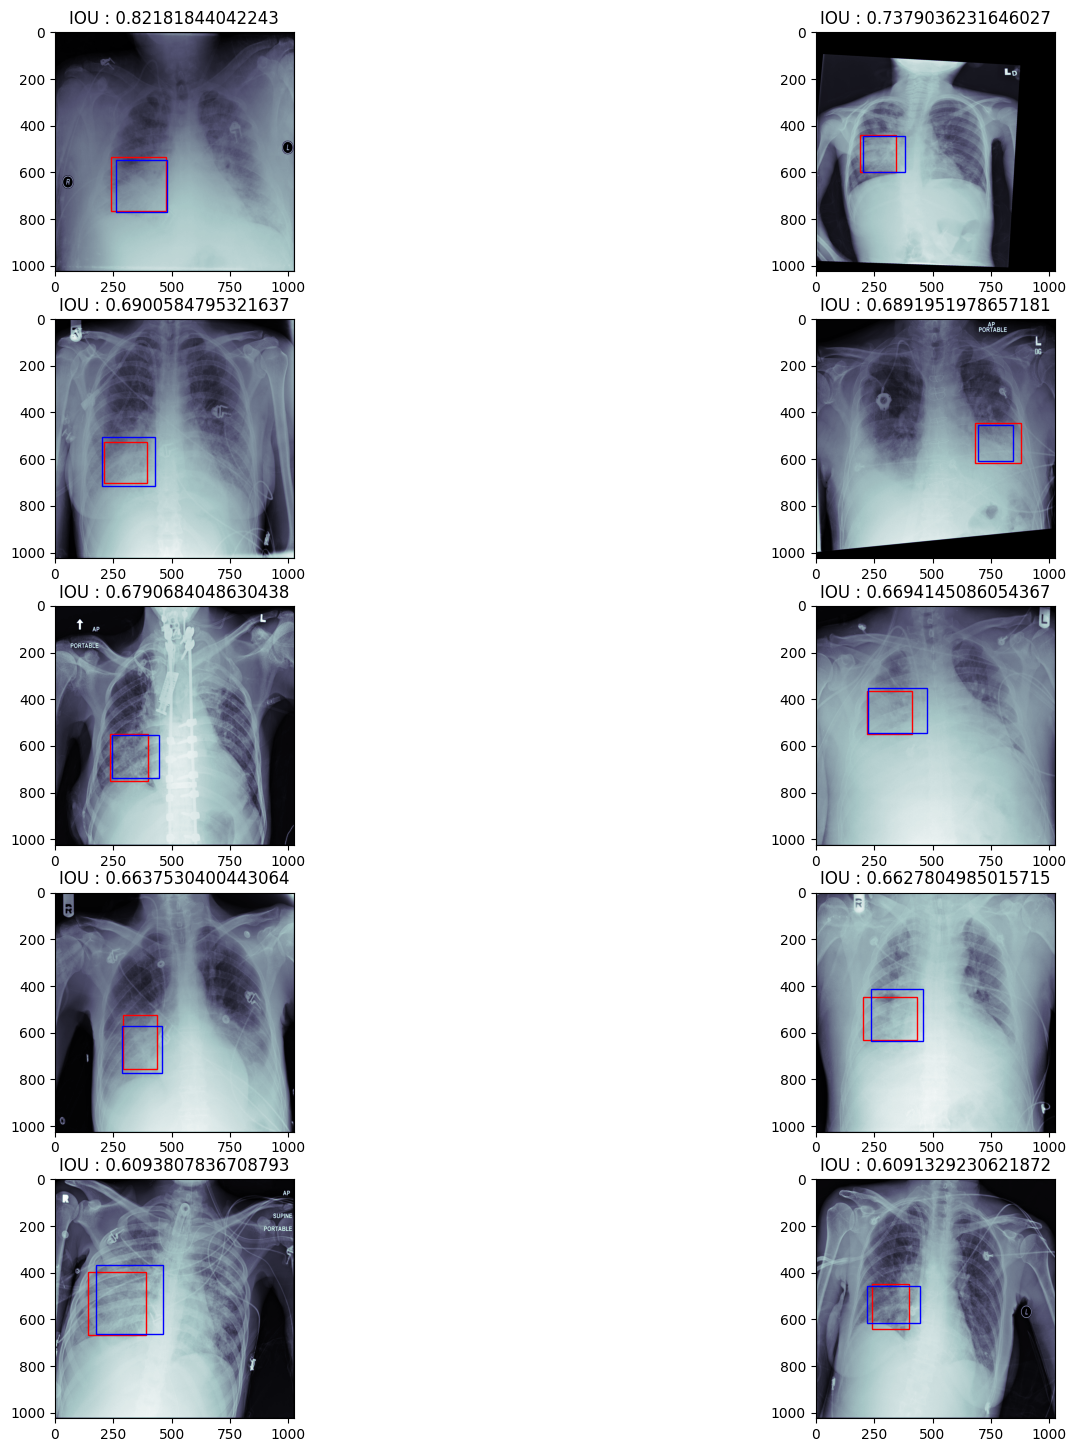

In [56]:
top = 10
visualizePredictions(report_file_ur, top)